In [1]:
# Show plots within the noteboook
%matplotlib inline 

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Required system Libraries 
import sys, os, datetime, time
import random

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Numeric libraries
import pandas as pd
import numpy as np 

# orchid-ml
from orchid_ml import MutationMatrix
from orchid_ml import load_matrix

import MySQLdb
from pprint import pprint

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

from slurpie import *

In [2]:
pilots = [['P0014-WBN', ['P0014-1A','P0014-1B','P0014-2C']],
          ['P0022-3N',  ['P0022-1A','P0022-2B']],
          ['P0023-5N',  ['P0023-2C','P0023-4B','P0023-6A']],
          ['P0024-4N',  ['P0024-2A']],
          ['P0039-5N',  ['P0039-2A','P0039-2B','P0039-2C']]]

In [3]:
panels = [
            [
                 'A_ms4po',
                 '../comparison_panels/orchid_panel.bed',
                 ["chromosome", "start", "stop", "id", "score"]
            ],[
                 'C_frequency',
                 '../comparison_panels/ICGC23_frequency_175bp.bed',
                 ["chromosome", "start", "stop"]
            ],[
                 'B_union',
                 '../comparison_panels/union_existing_seqcap_randomized.bed',
                 ["chromosome", "start", "stop", "name"]
            ]
         ]

In [4]:
## Relaxed for tumor: GATKStandardHaplotypeScore, GATKStandardMQ, GATKStandardQD
unacceptable = ['LowQual','GATKStandardReadPosRankSum','GATKStandardMQRankSum','GATKStandardFS']

In [5]:
directory = "../TN/pilot/"
final = None
all_found = None
all_kept  = None
all_tumor = None
## For each pilot sample
for pilot in pilots:
    ## FOR NORMALS
    # Get the filtered IHG GATK analysis file
    n_name = directory+"%s.vcf" % pilot[0]
    # Read in VCF variants
    norm = pd.read_csv(n_name, sep="\t", skiprows=126, index_col=False)
    # Get the ones without rsIDs and that PASS the filters (see VCF header for info)
    norm = norm[(norm['ID']=='.') & (norm['FILTER']=='PASS')]
    #norm = norm[(norm['FILTER']=='PASS')]
    #norm = norm[(norm['ID']=='.')]
    # Rename columns, drop index
    norm.columns = \
    ["chromosome", "position", "id", "ref", "alt", "qual", "filter", "info", "format", "other"]
    norm = norm.reset_index(drop=True)
    
    for t in pilot[1]:
        ## FOR FOCI
        # Get the filtered IHG GATK analysis file
        t_name = directory+"%s.vcf" % t
        # Read in the VCF variants
        tumor = pd.read_csv(t_name, sep="\t", skiprows=126, index_col=False)
        # Rename columns, drop index
        tumor.columns = \
        ["chromosome", "position", "id", "ref", "alt", "qual", "filter", "info", "format", "other"]
        tumor = tumor.reset_index(drop=True) 
        tumor['patient']=t.split('-')[0]
        tumor['focus']=t
        all_tumor = pd.concat([all_tumor,tumor])
        
        # Get the ones without rsIDs and that PASS the filters (see VCF header for info)
        ### NOTE: At most 4 variants detected if the following PASS is used!
        #tumor = tumor[(tumor['FILTER']=='PASS')]
        ### NOTE: Relaxed tumor filters used instead
        for un in unacceptable:
            tumor = tumor[~tumor['filter'].str.contains(un)]
        tumor = tumor[(tumor['id']=='.')]
    
        # Kept are those that only in the tumor
        kept = tumor.merge(norm.drop_duplicates(), how="left", 
                           on=["chromosome","position"], indicator=True)
        kept = kept[kept['_merge']=='left_only']
        #kept = tumor
        all_kept = pd.concat([kept,all_kept])
        
        # Evaluate each panel's performance
        for panel in panels:
            p = pd.read_csv(panel[1], sep="\t", index_col=False, header=None)
            p.columns = panel[2]
            
            count = 0
            for i,r in kept.iterrows():
                found = p[
                            (p['chromosome'] == r['chromosome']) & \
                            (p['start'] <= r['position']) & \
                            (p['stop']  >= r['position'])
                         ]
                if len(found)>0:
                    count += 1
                    r = pd.DataFrame(r).T
                    r['patient'] = t.split('-')[0]
                    r['panel'] = panel[0]
                    all_found = pd.concat([all_found,r[['patient','panel','chromosome','position']]])
                #count += sum(list((p['chromosome'] == r['chromosome']) & \
                #            (p['start'] <= r['position']) & \
                #            (p['stop']  >= r['position'])))
                #    count += 1
            result = pd.DataFrame([panel[0], t.split('-')[0], t, count, kept.shape[0]]).T
            final = pd.concat([final, result])
            
            
final.columns = ['Panel Name','Patient','Focus','Panel^Somatic','Somatic']
final['Panel^Somatic'] = final['Panel^Somatic'].astype(int)
final['Somatic'] = final['Somatic'].astype(int)
all_found = all_found.drop_duplicates()

In [6]:
totals = final[['Panel Name','Patient','Panel^Somatic','Somatic']]\
         .groupby(['Panel Name','Patient']).mean().reset_index()

In [25]:
sub = final[['Patient', 'Panel Name', 'Somatic', 'Panel^Somatic']]
sub['Log(S)'] = np.log10(sub['Somatic'])
sub['Log(PS)'] = np.log10(sub['Panel^Somatic'])

print sub[sub['Panel Name']=='A_ms4po'].groupby('Patient').mean()['Somatic']
print sub[sub['Panel Name']=='A_ms4po'].groupby('Patient').std()['Somatic']

Patient
P0014    274.333333
P0022    325.500000
P0023    322.666667
P0024    291.000000
P0039    334.333333
Name: Somatic, dtype: float64
Patient
P0014     6.658328
P0022    23.334524
P0023    20.502032
P0024          NaN
P0039    25.026652
Name: Somatic, dtype: float64


### Figure 3

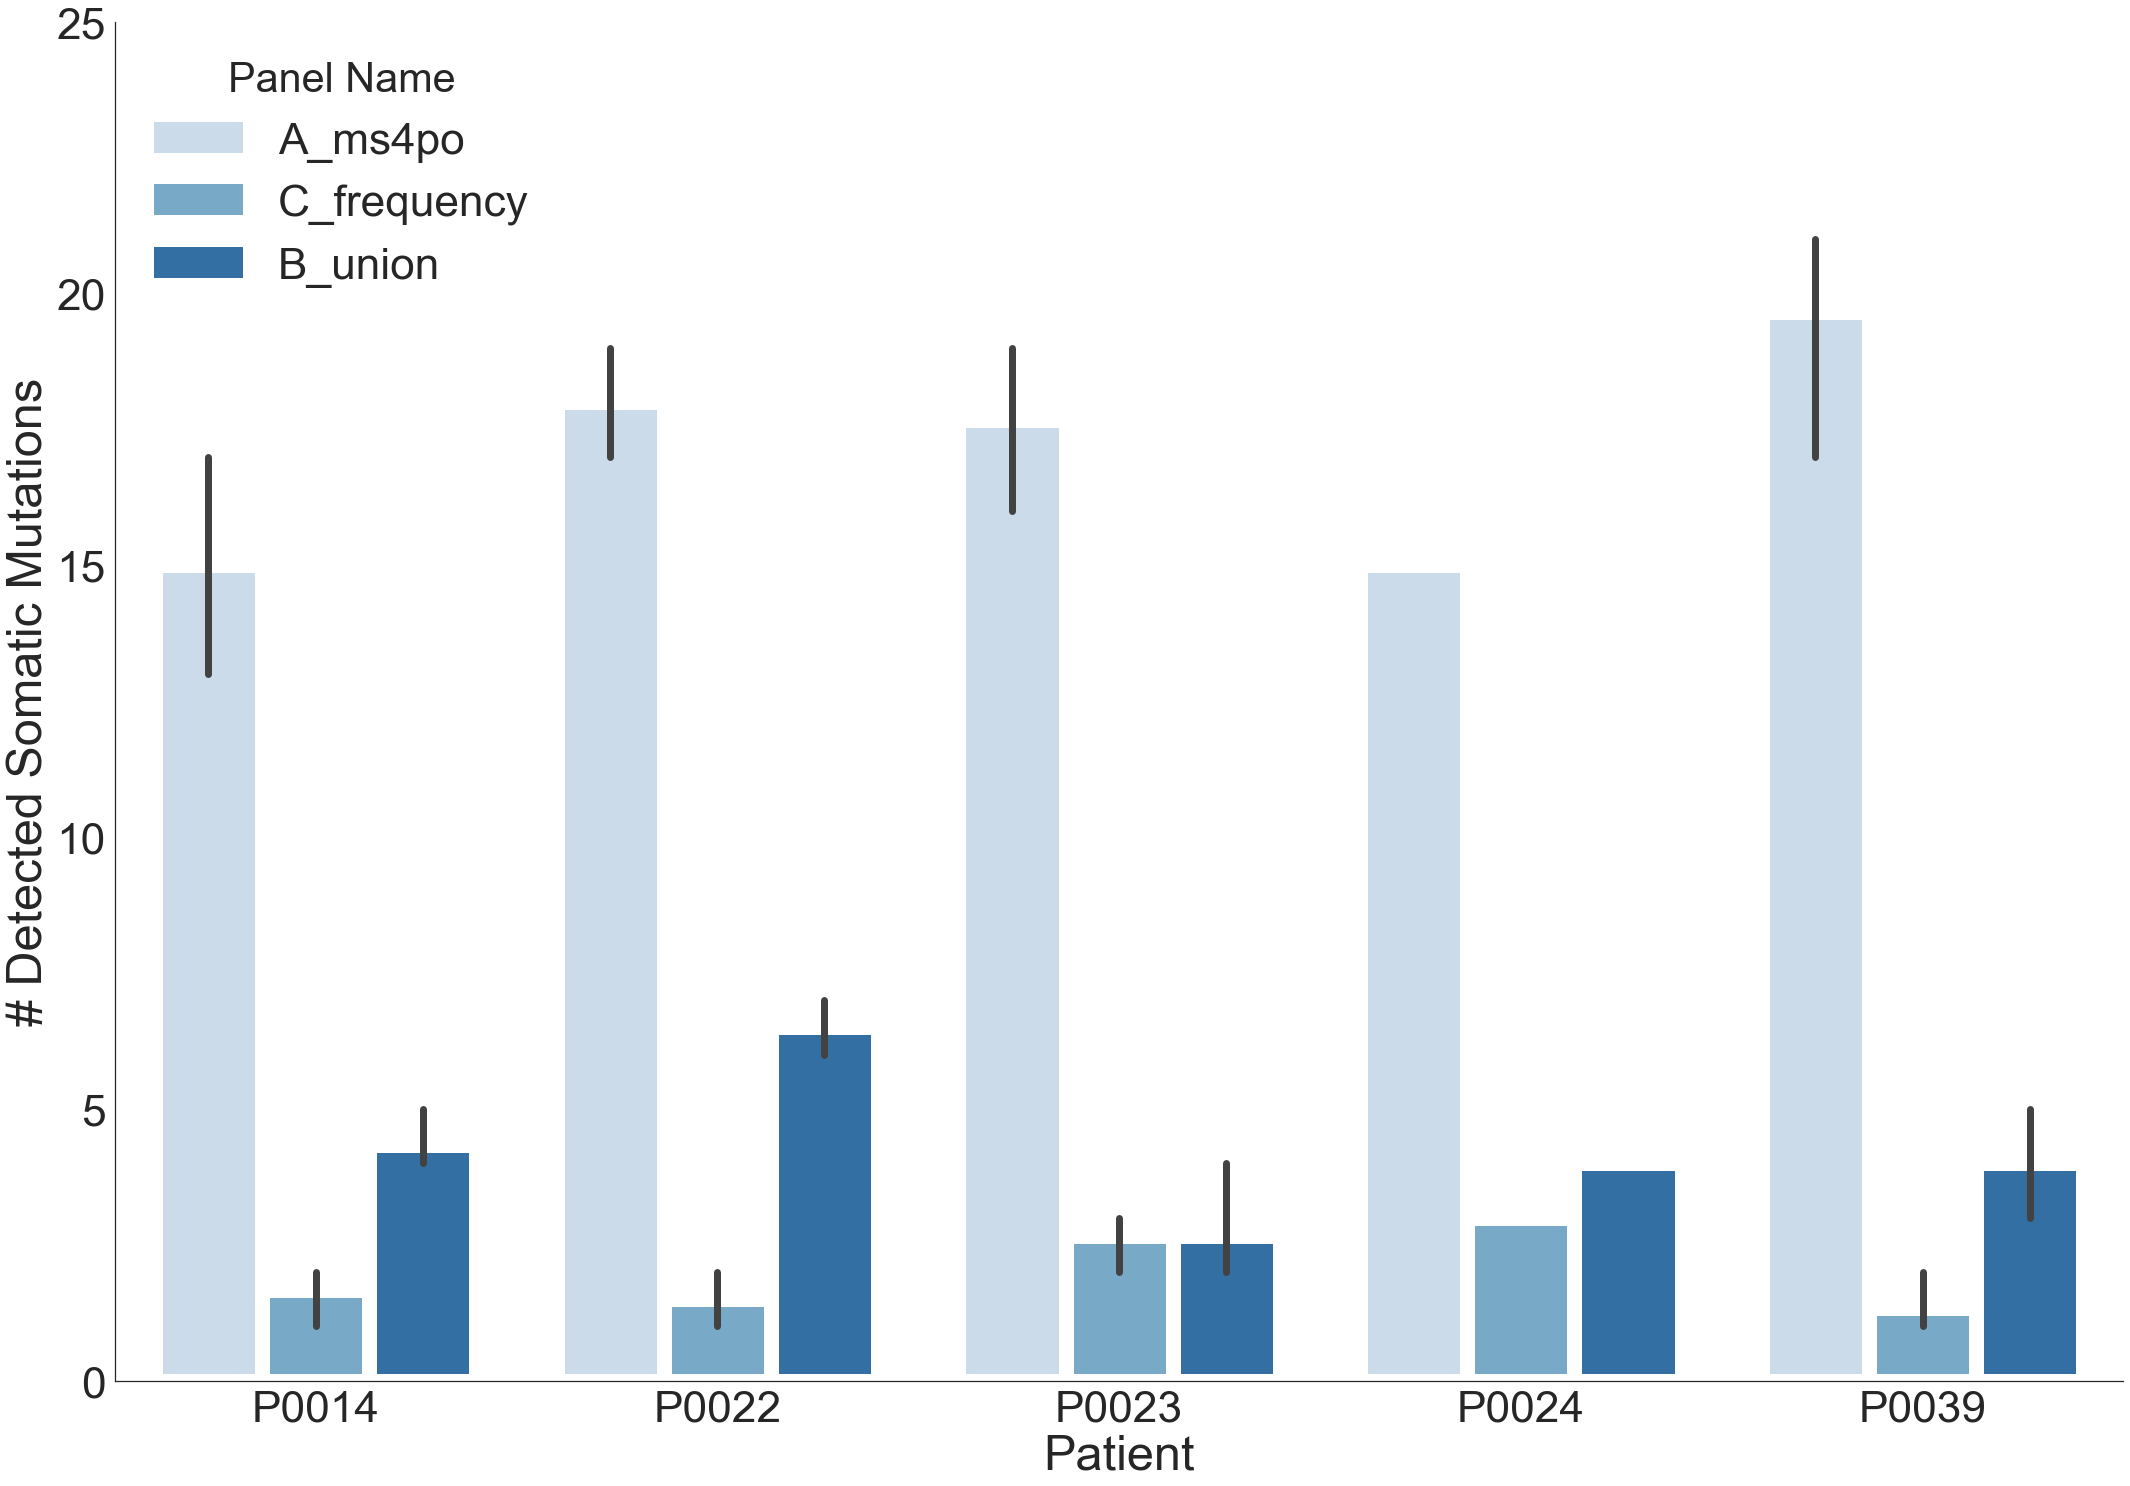

In [27]:
#colors = [(.5019,.8078,0.8549), (.298,.6862,.8823), (.0,.3372,.7450)]
#colors = ["#74DBEF", "#5E88FC", "#264E86"]
#colors = ["#11CBD7", "#C6F1E7", "#F0FFF3"]
#pal = sns.set_palette(sns.color_palette(colors))

sns.set_context("talk", font_scale=3.4)
fig, ax = plt.subplots(figsize=(36, 25))

# Plot panel bars
ax = sns.barplot(x="Patient", y="Panel^Somatic", hue="Panel Name", 
                 data=sub, palette="Blues", alpha=1, linewidth=15, 
                 errwidth=7)
# Outline panel bars in black
for i,patch in enumerate(ax.patches[0:]):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    patch.set_edgecolor("#FFFFFF")

sns.despine()
ax.set_ylabel("# Detected Somatic Mutations")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_ylim(0,25);

**Better feature weights (modeled independently)**

In [10]:
mutations = load_matrix("../SVMv4_Enrichment_20171107/prostate23_mutations.pkl")

In [11]:
new_features = pd.read_csv("../SVMv4_Enrichment_20171107/features.csv")[0:21]['Feature']

In [12]:
## Repeat for dann, phlyloP, cadd, cadd_raw, funseq2, and aa_class_change|unchanged
fws = pd.DataFrame(np.nan, index=new_features, columns=['Weight'])
fws.index.name='Feature'
fws = fws.reset_index()
for fea in new_features:
    print "Evaluating", fea
    feature_test = mutations.copy()
    feature_test.normalize_options['scaler_strat']='mms'
    feature_test.normalize_options['nan_strat']='mean'
    feature_test.set_features([fea])
    feature_test = feature_test.dropna(subset=[fea])
    feature_test.svm(cross_validate=False, test_size=0.0)
    ff  = feature_test.show_feature_importances('table')
    fws.loc[fws['Feature']==fea,'Weight'] \
      = feature_test.show_feature_importances('table').ix['False',fea]
fws = fws.sort_values('Weight', ascending=True)

Evaluating copy_number
Normalizing data.
... Columns with all NaN values will be set to 0.
... Imputing remaining NaNs using the 'mean' strategy.
... Scaling values with the 'mms' strategy.
Building a svm model using 100.00% of the data
... {'kernel': 'linear', 'probability': True, 'class_weight': 'balanced'}
Evaluating aa_class_change|unchanged
Normalizing data.
... Columns with all NaN values will be set to 0.
... Imputing remaining NaNs using the 'mean' strategy.
... Scaling values with the 'mms' strategy.
Building a svm model using 100.00% of the data
... {'kernel': 'linear', 'probability': True, 'class_weight': 'balanced'}
Evaluating phylop
Normalizing data.
... Columns with all NaN values will be set to 0.
... Imputing remaining NaNs using the 'mean' strategy.
... Scaling values with the 'mms' strategy.
Building a svm model using 100.00% of the data
... {'kernel': 'linear', 'probability': True, 'class_weight': 'balanced'}
Evaluating dann
Normalizing data.
... Columns with all NaN

In [13]:
fws

,Feature,Weight
0,copy_number,-14.416431
4,context|a[t>c]a,-2.000000
11,segmentation_huvec|r,-2.000000
8,segmentation_helas3|r,-2.000000
19,segmentation_hepg2|r,-2.000000
14,segmentation_h1hesc|r,-2.000000
7,segmentation_k562|r,-2.000000
9,remap,1.999949
12,aa_class_change|negative_=>_polar,2.000000
1,aa_class_change|unchanged,2.000000


In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cvals  = [-2., 0, 2]
colors = ['#9CECFB', '#65C7F7', '#0052D4']

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = mcolors.LinearSegmentedColormap.from_list("", tuples)

### Figure 1D

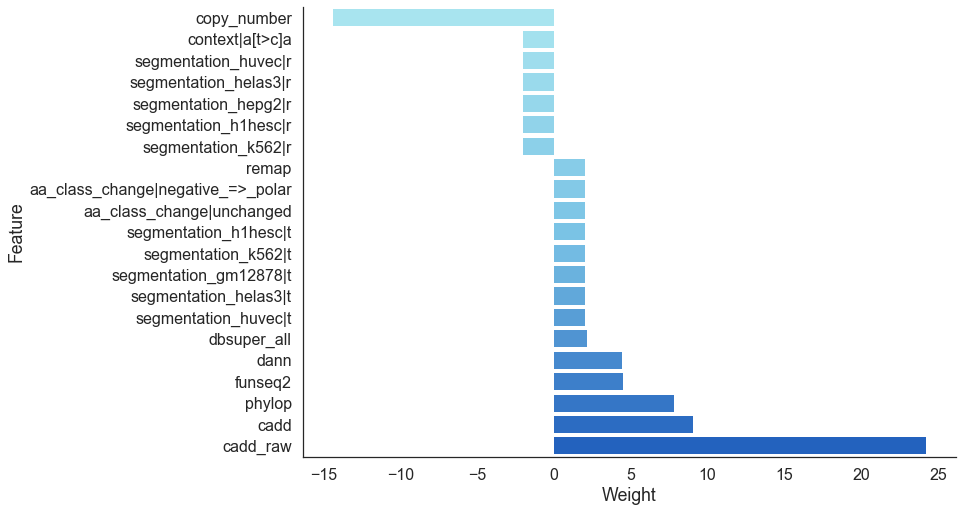

In [19]:
# And plot them
span, bot, top = (20,0,21)
mod = sns.color_palette(cmap(map(lambda k: k/float(top-bot), range(0,top-bot))))

sns.set_context("poster")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(11.7, 8.27))

ax=sns.barplot(y='Feature', x='Weight', data=fws,
                linewidth=2, palette=mod)
#ax.set_xlim(-3,3)


for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')
    artist.set_zorder(10)

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax2.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

sns.despine()